In [6]:
# Install NetworkX
import sys
!{sys.executable} -m pip install networkx==2.3

In [5]:
# Install matplotlib
!{sys.executable} -m pip install matplotlib

In [7]:
# Imports
import sys
import math
import unittest
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt

import pprint
pp = pprint.PrettyPrinter(indent=4)

In [8]:
G = nx.Graph() #tworzę graf

x1=0
x2=1
y1=0
y2=1
z1=0
z2=1

# Typ wierzchołka musi być wyróżniony
# w tym podejdziu zwykły wierzchołek zaczyna się na v, a hanging node na h
# jak widać w kodzie poniżej identyfikujemy typ po pierwszej literze

#           id,   x,    y,    z
G.add_node("v1", x=x1, y=y1, z=z1) #dodajemy wierzchołek
G.add_node("v2", x=x2, y=x2, z=z2) #dodajemy drugi wierzchołek
G.add_edge("v2", "v1") #dodajemy krawędź między wierzchołkami

v1 = G.nodes["v1"] #pobieramy wierzchołek który będzie nas interesował w kontekście krawędzi
v2 = G.nodes["v2"] #drugi wierzchołek krawędzi
attrs = {} #tak dodajemy atrybuty dla krawędzi, a krawędź ma atrybuty l i b
nx.set_edge_attributes(G, attrs) #aplikujemy atrybuty na krawędź

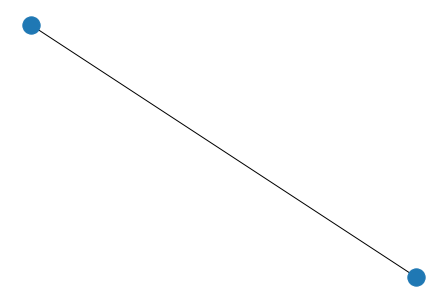

In [9]:
nx.draw(G)

zadanie polega na wyszukaniu w grafie, który został podany w sposób podany wyżej grafu, który spełnia warunki zadania

trójkąt o którym mowa może mieć hanging node, czyli specyficzny werzchołek, z którego nie ma połączenia do wnętrza, a który leży pomiędzy krawędziami

każde zadanie może mieć inne warunki na ilość hanging nodów

na wejście dostajemy id wierzchołka I, czyli tego środkowego

algorytm postępowania:

1. dostajemy i oraz G
2. znajdujemy sąsiadów i jeśli sąsiadów jest liczba mniejsza niż 3 to zwracamy false
3. jeśli jest 3 sąsiadów to określ trójkąt czyli połącznia między v1 v2 v3
4. L1=neighbours (v1, G)
5. L2=neighbours (v2, G)
6. if v1 należy do L2 i v2 należy do L1 (czyli jeśli jest pojedyncza krawędź) zwróć ją
7. else common=L1 przecięcie L2 i jeśli neighbour v1 jest hanging node i należy do common to zwróć dwie krawędzie - v1 z h i v2 z h, wpp. zwróć false

In [10]:
# Funkcja do budowania dicta ze współrzędnymi
# Taki dict jest wymagany przez funkcję rysującą
# jeżeli chcemy mieć poprawne rozmieszczenie
def build_pos_dict(G):
    xs = nx.get_node_attributes(G,'x')
    ys = nx.get_node_attributes(G,'y')

    keys = xs.keys()
    values = zip(xs.values(), ys.values())
    pos = dict(zip(keys, values))
    
    return pos

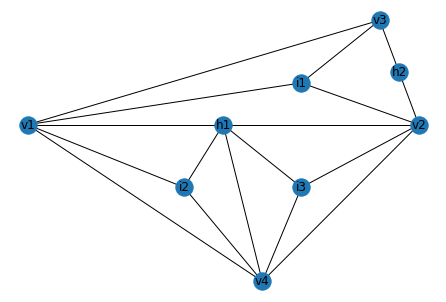

In [11]:
# Na wejściu dostajemy jakiś bardzo duży graf, który jest jakoś tam reprezentowany (na razie nie wiemy jak).
# Zakładamy jednak że mamy jakieś funkcje które parsują wejście i zwracają nam wszystkie potrzebne 
# dane, np w postaci dicta.
# Ogólnie to możemy założyć że wszystkie dane potrzebne do zbudowania grafu wejściowego są nam po prostu dostępne
# Poniżej graf na którym można testować swoje rozwiązanie

def get_test_graph():
    G = nx.Graph()
    vertices = {"v1": (0, 30, 0), 
                "v2": (10, 30, 0), 
                "v3": (9, 40, 0), 
                "h1": (5, 30, 0), 
                "h2": (9.5, 35, 0), 
                "i1": (7, 34, 0), 
                "v4": (6, 15, 0), 
                "i2": (4, 24, 0),
                "i3": (7, 24, 0)}
    for n, c in vertices.items():
        G.add_node(n, x=c[0], y=c[1], z=c[2])

    attrs = {"i1": {'R': True}, 
             "i2": {'R': False}, 
             "i3": {'R': False}}

    G.add_edge("v1", "h1", length = 5, name = 'e1')
    G.add_edge("v2", "h2", length = 5.0249, name = 'e2')
    G.add_edge("v2", "h1", length = 5, name = 'e3')
    G.add_edge("v3", "h2", length = 5.0249, name = 'e4')
    G.add_edge("v3", "v1", length = 13.4536, name = 'e5')
    G.add_edge("v1", "i1", length = 8.0623, name = 'e6')
    G.add_edge("v2", "i1", length = 5, name = 'e7')
    G.add_edge("v3", "i1", length = 6.3246, name = 'e8')
    G.add_edge("v4", "v1", length = 16.1555, name = 'e9')
    G.add_edge("v4", "v2", length = 15.5242, name = 'e10')
    G.add_edge("v4", "h1", length = 15.0333, name = 'e11')
    G.add_edge("v1", "i2", length = 7.2111, name = 'e12')
    G.add_edge("h1", "i2", length = 6.0828, name = 'e13')
    G.add_edge("v4", "i2", length = 9.2195, name = 'e14')
    G.add_edge("i3", "v4", length = 9.0554, name = 'e15')
    G.add_edge("i3", "v2", length = 6.7082, name = 'e16')
    G.add_edge("i3", "h1", length = 6.3246, name = 'e17')
    
    nx.set_node_attributes(G, attrs)
    
    return G

# NetworkX: aby narysować graf z dobrym rozmieszczeniem, musimy przekazać
# sam graf oraz osobno dict z współrzędnymi (x,y)
G = get_test_graph()
nx.draw(G, build_pos_dict(G), with_labels = True)

powstał na górze graf przykładowy, który wskazał dr. Paszyński jako przykład, że jak z tym sobie program poradzi to ze wszystkim sobie poradzi

# P6

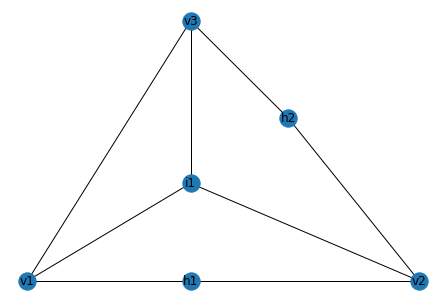

In [9]:
def get_valid_P6_graph():
    G = nx.Graph()
    vertices = {"v1": (0, 0, 0), 
                "h1": (5, 0, 0), 
                "v2": (12, 0, 0), 
                "h2": (8, 5, 0),
                "v3": (5, 8, 0),
                "i1": (5,3,0)
               }
                
    for n, c in vertices.items():
        G.add_node(n, x=c[0], y=c[1], z=c[2])

    attrs = {"i1": {'R': True}, 
             "i2": {'R': False}, 
             "i3": {'R': False}}
    nx.set_node_attributes(G, attrs)

    G.add_edge("v1", "h1", length = 5, B=False)
    G.add_edge("v2", "h1", length = 7, B=False)
    G.add_edge("v2", "h2", length = 6.4, B=False)
    G.add_edge("v3", "h2", length = 4.2, B=False)
    G.add_edge("v3", "v1", length = 11, B=False)
    G.add_edge("i1", "v1", B=False)
    G.add_edge("i1", "v2", B=False)
    G.add_edge("i1", "v3", B=False)
    
    return G

G = get_valid_P6_graph()
nx.draw(G, build_pos_dict(G), with_labels = True)

In [10]:
def get_graph_layout_P6(G, i):
    h = None
    v1 = None
    v2 = None
    v3 = None
    
    edges = {}
    longest_edge_sum = 0
    edge_without_hanging_node=None
    not_vs = ()
      
    for vi,vj in combinations(list(G.neighbors(i)),2):
        key = (vi,vj)
        if vi.startswith('h') or vj.startswith('h'):
            return (edges, v1, v2, v3, h);
        edges[key] = []
        if (vi in list(G.neighbors(vj))) and (vj in list(G.neighbors(vi))):
            if len(edges[key])==0:
                edges[key].append(G.edges[vi, vj])
                edge_without_hanging_node = edges[key][0]
            else:
                return (None, None, None, None)
        else:
            if any(t.startswith('h') for t in sorted(nx.common_neighbors(G, vi, vj))):
                h_node=next((x for x in sorted(nx.common_neighbors(G, vi, vj)) if x.startswith('h')), None)
                edges[key].append(G.edges[vi,h_node])
                edges[key].append(G.edges[vj,h_node])
                length = G.edges[vi,h_node]['length'] + G.edges[vj,h_node]['length']
                if (length > longest_edge_sum):
                    longest_edge_sum = length
                    h = h_node
                    not_vs = (vi,vj)
    
    counter = 0
    for k,v in edges.items():
        if len(v)==2:
            counter=counter+1
    if counter != 2:
        return (None, None, None, None, None)
    
    v3 = [v for v in list(G.neighbors(i)) if v not in not_vs][0]
    if len(not_vs)!=0:
        if any(t.startswith('h') for t in sorted(nx.common_neighbors(G, v3, not_vs[0]))):
            v1 = not_vs[1]
            v2 = not_vs[0]
        else:
            v1 = not_vs[0]
            v2 = not_vs[1]

    return (edges, v1, v2, v3, h)

In [11]:
def is_P6_possible(G, i):
    if len(list(G.neighbors(i)))!=3:
        return False
    else:    
        (edges, v1, v2, v3, h) = get_graph_layout_P6(G,i)
        pp.pprint(edges)
        print(v1, v2, v3, h)
        if not v3: return False
    
    if is_condition_P6_fulfilled(edges, v3): 
        return True
    else: return False
    
    
def is_condition_P6_fulfilled(edges, v3):
    l1=l2=l3=l4=l5=0
    
    for (vi,vj), edge in edges.items():
        if v3 not in (vi,vj):
            l1 = edge[0]['length']
            l2 = edge[1]['length']
        elif len(edge)==1:
            l5 = edge[0]['length']
        else:
            l3 = edge[0]['length']
            l4 = edge[1]['length']
    
    if ((l1+l2) >= l3+l4) and ((l1+l2)>=l5):
        print('Condition P6 passed')
        return True
    else:
        print('Condition P6 failed')
        return False

In [12]:
def transform_P6(G, i_node):
    (edges, v1, v2, v3, h_node) = get_graph_layout_P6(G,i)
   
    # zmiana h_node na normalny node z tymi samymi współrzędnymi
    last_v_index = next((x for x in sorted(list(G.nodes),reverse=True ) if x.startswith('v')), None)
    current_number = int(last_v_index[1:]) + 1
    new_v_node = "v" + str(current_number)
        
    x1 = G.nodes[h_node]['x']
    y1 = G.nodes[h_node]['y']
    z1 = G.nodes[h_node]['z']
    
    mapping={h_node: new_v_node}
    G=nx.relabel_nodes(G,mapping)
    
    #krawędź:
    l6 = math.sqrt(math.pow(x1 - G.nodes[v3]['x'], 2) + math.pow(y1 - G.nodes[v3]['y'], 2) \
                   + math.pow(z1 - G.nodes[v3]['z'], 2))
    G.add_edge(v3, new_v_node, B = False, length = l6)

    #nowy punkt i1:
    last_i_index = next((x for x in sorted(list(G.nodes),reverse=True ) if x.startswith('i')), None)
    current_number = int(last_i_index[1:]) + 1
    new_i_node = "i" + str(current_number)
    x_i1 = (G.node[new_v_node]['x'])/3 + (G.node[v1]['x'])/3 + (G.node[v3]['x'])/3
    y_i1 = (G.node[new_v_node]['y'])/3 + (G.node[v1]['y'])/3 + (G.node[v3]['y'])/3
    z_i1 = (G.node[new_v_node]['z'])/3 + (G.node[v1]['z'])/3 + (G.node[v3]['z'])/3 
    G.add_node(new_i_node, x=x_i1, y=y_i1, z=z_i1)
    
    G.add_edge(new_i_node, v1)
    G.add_edge(new_i_node, v3)
    G.add_edge(new_i_node, new_v_node)
    
    #nowy punkt i2:
    last_i_index = next((x for x in sorted(list(G.nodes),reverse=True ) if x.startswith('i')), None)
    current_number = int(last_i_index[1:]) + 1
    new_i_node = "i" + str(current_number)
    x_i2 = (G.node[new_v_node]['x'])/3 + (G.node[v2]['x'])/3 + (G.node[v3]['x'])/3
    y_i2 = (G.node[new_v_node]['y'])/3 + (G.node[v2]['y'])/3 + (G.node[v3]['y'])/3
    z_i2 = (G.node[new_v_node]['z'])/3 + (G.node[v2]['z'])/3 + (G.node[v3]['z'])/3 
    G.add_node(new_i_node, x=x_i2, y=y_i2, z=z_i2)
      
    G.add_edge(new_i_node, v3)
    G.add_edge(new_i_node, v2)
    G.add_edge(new_i_node, new_v_node)

    attrs = {
        "i2": {'R': False}, 
        "i3": {'R': False}}
    nx.set_node_attributes(G, attrs)
        
    G.remove_node(i)

    return G

In [13]:
i = "i1"
G = get_test_graph()
check = is_P6_possible(G, i)
if check: 
    G = transform_P6(G, i)
    nx.draw(G, build_pos_dict(G), with_labels = True)
else:
    print("P6 not possible on this graph for " + i)

{   ('v1', 'v2'): [{'length': 5, 'name': 'e1'}, {'length': 5, 'name': 'e3'}],
    ('v1', 'v3'): [{'length': 13.4536, 'name': 'e5'}],
    ('v2', 'v3'): [   {'length': 5.0249, 'name': 'e2'},
                      {'length': 5.0249, 'name': 'e4'}]}
v3 v2 v1 h2
Condition P6 failed
P6 not possible on this graph for i1


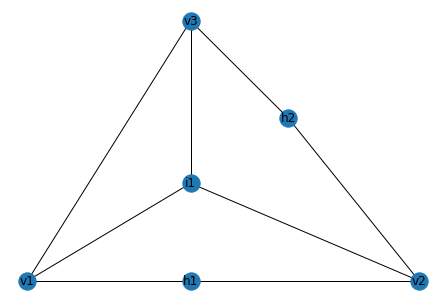

In [14]:
G = get_valid_P6_graph()
nx.draw(G, build_pos_dict(G), with_labels = True)

{   ('v1', 'v2'): [{'B': False, 'length': 5}, {'B': False, 'length': 7}],
    ('v1', 'v3'): [{'B': False, 'length': 11}],
    ('v2', 'v3'): [{'B': False, 'length': 6.4}, {'B': False, 'length': 4.2}]}
v1 v2 v3 h1
Condition P6 passed


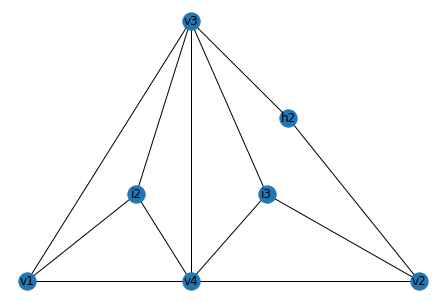

In [15]:
i = "i1"
G = get_valid_P6_graph()
check = is_P6_possible(G, i)
if check: 
    G = transform_P6(G, i)
    nx.draw(G, build_pos_dict(G), with_labels = True)
else:
    print("P6 not possible on this graph for " + i)

# P7

In [8]:
def find_graph_P7(G, i):
    # Jak i nie ma trzech sąsiadów to od razu wracamy
    if len(list(G.neighbors(i)))!=3:
        return False
    # będziemy szukać krawędzi która nie ma hanging node
    # to nam zoritentuje graf
    else:
        v1 = list(G.neighbors(i))[0]
        v2 = list(G.neighbors(i))[1]
        v3 = list(G.neighbors(i))[2]
        e1 = []
        e2 = []
        e3 = []
        edge_without_hanging_node=None
        
        #szukam krawędzi między v1 i v2
        if (v1 in list(G.neighbors(v2))) and (v2 in list(G.neighbors(v1))):
            e1 = G.edges[v1, v2]
            edge_without_hanging_node = e1
        else:
            if any(t.startswith('h') for t in sorted(nx.common_neighbors(G, v1, v2))):
                h_edge=next((x for x in sorted(nx.common_neighbors(G, v1, v2)) if x.startswith('h')), None)
                e1.append(G.edges[v1,h_edge])
                e1.append(G.edges[v2,h_edge])
            else:
                return False
          
        # między v2 i v3
        if (v2 in list(G.neighbors(v3))) and (v3 in list(G.neighbors(v2))):
            e2 = G.edges[v2, v3]
            if edge_without_hanging_node == None:
                edge_without_hanging_node = e2
            else:
                return False
        else:
            if any(t.startswith('h') for t in sorted(nx.common_neighbors(G, v2, v3))):
                h_edge=next((x for x in sorted(nx.common_neighbors(G, v2, v3)) if x.startswith('h')), None)
                e2.append(G.edges[v2,h_edge])
                e2.append(G.edges[v3,h_edge])
            else:
                return False
            
        # między v3 i v1    
        if (v1 in list(G.neighbors(v3))) and (v3 in list(G.neighbors(v1))):
            e3 = G.edges[v1, v3]
            if edge_without_hanging_node == None:
                edge_without_hanging_node = e3
            else:
                return False
        else:
            if any(t.startswith('h') for t in sorted(nx.common_neighbors(G, v1, v3))):
                h_edge=next((x for x in sorted(nx.common_neighbors(G, v1, v3)) if x.startswith('h')), None)
                e3.append(G.edges[v1,h_edge])
                e3.append(G.edges[v3,h_edge])
            else:
                return False
    print (e1)
    print (e2)
    print (e3)
    print (edge_without_hanging_node)
    
    
    # sprawdzenie zadanego warunku:
    if (e1==edge_without_hanging_node) and (edge_without_hanging_node['length'])<=(e2[0]['length'])+(e2[1]['length']) and (edge_without_hanging_node['length'])<=(e3[0]['length'])+(e3[1]['length']):
        return False
    if (e2==edge_without_hanging_node) and (edge_without_hanging_node['length'])<=(e1[0]['length'])+(e1[1]['length']) and (edge_without_hanging_node['length'])<=(e3[0]['length'])+(e3[1]['length']):
        return False
    if (e3==edge_without_hanging_node) and (edge_without_hanging_node['length'])<=(e2[0]['length'])+(e2[1]['length']) and (edge_without_hanging_node['length'])<=(e1[0]['length'])+(e1[1]['length']):
        return False
    
    # usuwam punkt I
    # usunięcie node'a od razu pociąga za sobą usunięcie jego krawędzi
    G.remove_node(i)
    
    #nowy punkt V:
    last_v_index = next((x for x in sorted(list(G.nodes),reverse=True ) if x.startswith('v')), None)
    current_number = int(last_v_index[1:]) + 1
    new_v_node = "v" + str(current_number)
    print ("nowy punkt v będzie się nazywał: " + new_v_node)
    G.add_node(new_v_node)
    
    #nowe punkty I:
    last_i_index = next((x for x in sorted(list(G.nodes),reverse=True ) if x.startswith('i')), None)
    current_number = int(last_i_index[1:]) + 1
    new_i_node = "i" + str(current_number)
    print ("nowy punkt i będzie się nazywał: " + new_i_node)
    
    last_i_index = next((x for x in sorted(list(G.nodes),reverse=True ) if x.startswith('i')), None)
    current_number = int(last_i_index[1:]) + 2
    new_i_node2 = "i" + str(current_number)
    print ("nowy punkt i będzie się nazywał: " + new_i_node2)
    
    
    if (e1==edge_without_hanging_node):
        print ("nowy wierzcholek ma byc miedzy v1 a v2")
        l2 = nx.get_edge_attributes(G,'length')[(v1,v2)]
        G.remove_edge(v1, v2)
        
        new_x = (G.node[v1]['x']/2) + (G.node[v2]['x']/2)
        new_y = (G.node[v1]['y']/2) + (G.node[v2]['y']/2)
        new_z = (G.node[v1]['z']/2) + (G.node[v2]['z']/2)
        
        # dodajemy nowy node
        G.add_node(new_v_node, x=new_x, y=new_y, z=new_z);
        
        # nowe edże
        G.add_edge(v1, new_v_node, length = l2/2)
        G.add_edge(v2, new_v_node, length = l2/2)
        
        # add new_i1 positions
        new_x_for_i = (G.node[new_v_node]['x'])/3 + (G.node[v2]['x'])/3 + (G.node[v3]['x'])/3
        new_y_for_i = (G.node[new_v_node]['y'])/3 + (G.node[v2]['y'])/3 + (G.node[v3]['y'])/3
        new_z_for_i = (G.node[new_v_node]['z'])/3 + (G.node[v2]['z'])/3 + (G.node[v3]['z'])/3                                                                       
        G.add_node(new_i_node, x=new_x_for_i, y=new_y_for_i, z=new_z_for_i); 
        attrs[new_i_node] = {'R': False}
        G.add_edge(new_v_node, new_i_node)
        G.add_edge(v2, new_i_node)
        G.add_edge(v3, new_i_node)
        
        # add new_i2 positions
        new_x_for_i2 = (G.node[new_v_node]['x'])/3 + (G.node[v2]['x'])/3 + (G.node[v1]['x'])/3
        new_y_for_i2 = (G.node[new_v_node]['y'])/3 + (G.node[v2]['y'])/3 + (G.node[v1]['y'])/3
        new_z_for_i2 = (G.node[new_v_node]['z'])/3 + (G.node[v2]['z'])/3 + (G.node[v1]['z'])/3
        G.add_node(new_i_node2, x=new_x_for_i2, y=new_y_for_i2, z=new_z_for_i2);
        attrs[new_i_node2] = {'R': False}
        G.add_edge(new_v_node, new_i_node2)
        G.add_edge(v1, new_i_node2)
        G.add_edge(v3, new_i_node2)
    
        last_edge_length=math.sqrt(math.pow(G.node[v3]['x'] - new_x, 2) + math.pow(G.node[v3]['y'] - new_y, 2))
        G.add_edge(new_v_node, v3)
        
    elif (e2==edge_without_hanging_node):
        print ("nowy wierzcholek ma byc miedzy v2 a v3")
        l2 = nx.get_edge_attributes(G,'length')[(v3,v2)]
        G.remove_edge(v2, v3)
        
        new_x = (G.node[v3]['x']/2) + (G.node[v2]['x']/2)
        new_y = (G.node[v3]['y']/2) + (G.node[v2]['y']/2)
        new_z = (G.node[v3]['z']/2) + (G.node[v2]['z']/2)
        
        # dodajemy nowy node
        G.add_node(new_v_node, x=new_x, y=new_y, z=new_z);
        
        # nowe edże
        G.add_edge(v2, new_v_node, length = l2/2)
        G.add_edge(v3, new_v_node, length = l2/2)
        
        #add new i1 positions
        new_x_for_i = (G.node[new_v_node]['x'])/3 + (G.node[v3]['x'])/3 + (G.node[v1]['x'])/3
        new_y_for_i = (G.node[new_v_node]['y'])/3 + (G.node[v3]['y'])/3 + (G.node[v1]['y'])/3
        new_z_for_i = (G.node[new_v_node]['z'])/3 + (G.node[v3]['z'])/3 + (G.node[v1]['z'])/3
        G.add_node(new_i_node, x=new_x_for_i, y=new_y_for_i, z=new_z_for_i);  
        attrs[new_i_node] = {'R': False}
        G.add_edge(new_v_node, new_i_node)
        G.add_edge(v3, new_i_node)
        G.add_edge(v2, new_i_node)
        
        new_x_for_i2 = (G.node[new_v_node]['x'])/3 + (G.node[v2]['x'])/3 + (G.node[v1]['x'])/3
        new_y_for_i2 = (G.node[new_v_node]['y'])/3 + (G.node[v2]['y'])/3 + (G.node[v1]['y'])/3
        new_z_for_i2 = (G.node[new_v_node]['z'])/3 + (G.node[v2]['z'])/3 + (G.node[v1]['z'])/3
        G.add_node(new_i_node2, x=new_x_for_i2, y=new_y_for_i2, z=new_z_for_i2);
        attrs[new_i_node2] = {'R': False}
        G.add_edge(new_v_node, new_i_node2)
        G.add_edge(v1, new_i_node2)
        G.add_edge(v2, new_i_node2)
        
        last_edge_length=math.sqrt(math.pow(G.node[v1]['x'] - new_x, 2) + math.pow(G.node[v1]['y'] - new_y, 2))
        G.add_edge(new_v_node, v1, length=last_edge_length)
        
    elif (e3==edge_without_hanging_node):
        print("nowy wierzcholek ma byc miedzy v1 a v3")
        l2 = nx.get_edge_attributes(G,'length')[(v1,v3)]
        G.remove_edge(v1, v3)
        
        new_x = (G.node[v1]['x']/2) + (G.node[v3]['x']/2)
        new_y = (G.node[v1]['y']/2) + (G.node[v3]['y']/2)
        new_z = (G.node[v1]['z']/2) + (G.node[v3]['z']/2)
        
        # dodajemy nowy node
        G.add_node(new_v_node, x=new_x, y=new_y, z=new_z);
        
        # nowe edże
        G.add_edge(v1, new_v_node, length = l2/2)
        G.add_edge(v3, new_v_node, length = l2/2)
        
        # add new_i1 positions
        new_x_for_i = (G.node[new_v_node]['x'])/3 + (G.node[v3]['x'])/3 + (G.node[v2]['x'])/3
        new_y_for_i = (G.node[new_v_node]['y'])/3 + (G.node[v3]['y'])/3 + (G.node[v2]['y'])/3
        new_z_for_i = (G.node[new_v_node]['z'])/3 + (G.node[v3]['z'])/3 + (G.node[v2]['z'])/3                                                                       
        G.add_node(new_i_node, x=new_x_for_i, y=new_y_for_i, z=new_z_for_i);                                                                          
        attrs[new_i_node] = {'R': False}                                                                          
        G.add_edge(new_v_node, new_i_node)
        G.add_edge(v3, new_i_node)
        G.add_edge(v2, new_i_node)
        
        new_x_for_i2 = (G.node[new_v_node]['x'])/3 + (G.node[v2]['x'])/3 + (G.node[v1]['x'])/3
        new_y_for_i2 = (G.node[new_v_node]['y'])/3 + (G.node[v2]['y'])/3 + (G.node[v1]['y'])/3
        new_z_for_i2 = (G.node[new_v_node]['z'])/3 + (G.node[v2]['z'])/3 + (G.node[v1]['z'])/3
        G.add_node(new_i_node2, x=new_x_for_i2, y=new_y_for_i2, z=new_z_for_i2);
        attrs[new_i_node2] = {'R': False}
        G.add_edge(new_v_node, new_i_node2)
        G.add_edge(v1, new_i_node2)
        G.add_edge(v2, new_i_node2)
        
        last_edge_length=math.sqrt(math.pow(G.node[v2]['x'] - new_x, 2) + math.pow(G.node[v2]['y'] - new_y, 2))
        G.add_edge(new_v_node, v2, length=last_edge_length)
        
    nx.set_node_attributes(G, attrs)
    nx.draw(G, build_pos_dict(G), with_labels = True)
    return True
    

[{'length': 5, 'name': 'e1'}, {'length': 5, 'name': 'e3'}]
[{'length': 5.0249, 'name': 'e2'}, {'length': 5.0249, 'name': 'e4'}]
{'length': 13.4536, 'name': 'e5'}
{'length': 13.4536, 'name': 'e5'}
nowy punkt v będzie się nazywał: v5
nowy punkt i będzie się nazywał: i4
nowy punkt i będzie się nazywał: i5
nowy wierzcholek ma byc miedzy v1 a v3
True


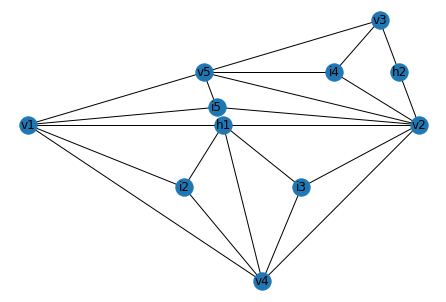

In [9]:
G = get_test_graph()
print(find_graph_P7(G, "i1"))

# P8

In [17]:
def find_graph_P8(G, i):
    # Jak i nie ma trzech sąsiadów to od razu wracamy
    if len(list(G.neighbors(i)))!=3:
        return False
    # będziemy szukać krawędzi która nie ma hanging node
    # to nam zoritentuje graf
    else:
        v1 = list(G.neighbors(i))[1]
        v2 = list(G.neighbors(i))[0]
        v3 = list(G.neighbors(i))[2]
        e1 = []
        e2 = []
        e3 = []
        edge_without_hanging_node=None
        
        #szukam krawędzi między v1 i v2
        if (v1 in list(G.neighbors(v2))) and (v2 in list(G.neighbors(v1))):
            e1 = G.edges[v1, v2]
            edge_without_hanging_node = e1
        else:
            if any(t.startswith('h') for t in sorted(nx.common_neighbors(G, v1, v2))):
                h_edge=next((x for x in sorted(nx.common_neighbors(G, v1, v2)) if x.startswith('h')), None)
                e1.append(G.edges[v1,h_edge])
                e1.append(G.edges[v2,h_edge])
            else:
                return False
          
        # między v2 i v3
        if (v2 in list(G.neighbors(v3))) and (v3 in list(G.neighbors(v2))):
            e2 = G.edges[v2, v3]
            if edge_without_hanging_node == None:
                edge_without_hanging_node = e2
            else:
                return False
        else:
            if any(t.startswith('h') for t in sorted(nx.common_neighbors(G, v2, v3))):
                h_edge=next((x for x in sorted(nx.common_neighbors(G, v2, v3)) if x.startswith('h')), None)
                e2.append(G.edges[v2,h_edge])
                e2.append(G.edges[v3,h_edge])
            else:
                return False
            
        # między v3 i v1    
        if (v1 in list(G.neighbors(v3))) and (v3 in list(G.neighbors(v1))):
            e3 = G.edges[v1, v3]
            if edge_without_hanging_node == None:
                edge_without_hanging_node = e3
            else:
                return False
        else:
            if any(t.startswith('h') for t in sorted(nx.common_neighbors(G, v1, v3))):
                h_edge=next((x for x in sorted(nx.common_neighbors(G, v1, v3)) if x.startswith('h')), None)
                e3.append(G.edges[v1,h_edge])
                e3.append(G.edges[v3,h_edge])
            else:
                return False
    print (e1)
    print (e2)
    print (e3)
    print (edge_without_hanging_node)
    
    
    # sprawdzenie zadanego warunku:
    if (e1==edge_without_hanging_node) and (edge_without_hanging_node['length'])<=(e2[0]['length'])+(e2[1]['length']) and (edge_without_hanging_node['length'])<=(e3[0]['length'])+(e3[1]['length']):
        return False
    if (e2==edge_without_hanging_node) and (edge_without_hanging_node['length'])<=(e1[0]['length'])+(e1[1]['length']) and (edge_without_hanging_node['length'])<=(e3[0]['length'])+(e3[1]['length']):
        return False
    if (e3==edge_without_hanging_node) and (edge_without_hanging_node['length'])<=(e2[0]['length'])+(e2[1]['length']) and (edge_without_hanging_node['length'])<=(e1[0]['length'])+(e1[1]['length']):
        return False
    
    # usuwam punkt I
    # usunięcie node'a od razu pociąga za sobą usunięcie jego krawędzi
    G.remove_node(i)
    
    #nowy punkt H:
    last_h_index = next((x for x in sorted(list(G.nodes),reverse=True ) if x.startswith('h')), None)
    current_number = int(last_h_index[1:]) + 1
    new_h_node = "h" + str(current_number)
    print ("nowy punkt h będzie się nazywał: " + new_h_node)
    G.add_node(new_h_node)
    
    #nowe punkty I:
    last_i_index = next((x for x in sorted(list(G.nodes),reverse=True ) if x.startswith('i')), None)
    current_number = int(last_i_index[1:]) + 1
    new_i_node = "i" + str(current_number)
    print ("nowy punkt i będzie się nazywał: " + new_i_node)
    
    last_i_index = next((x for x in sorted(list(G.nodes),reverse=True ) if x.startswith('i')), None)
    current_number = int(last_i_index[1:]) + 2
    new_i_node2 = "i" + str(current_number)
    print ("nowy punkt i będzie się nazywał: " + new_i_node2)
    
    
    if (e1==edge_without_hanging_node):
        print ("nowy wierzcholek ma byc miedzy v1 a v2")
        l2 = nx.get_edge_attributes(G,'length')[(v1,v2)]
        G.remove_edge(v1, v2)
        
        new_x = (G.node[v1]['x']/2) + (G.node[v2]['x']/2)
        new_y = (G.node[v1]['y']/2) + (G.node[v2]['y']/2)
        new_z = (G.node[v1]['z']/2) + (G.node[v2]['z']/2)
        
        # dodajemy nowy node
        G.add_node(new_h_node, x=new_x, y=new_y, z=new_z);
        
        # nowe edge
        G.add_edge(v1, new_h_node, length = l2/2)
        G.add_edge(v2, new_h_node, length = l2/2)
        
        # add new_i1 positions
        new_x_for_i = (G.node[new_h_node]['x'])/3 + (G.node[v2]['x'])/3 + (G.node[v3]['x'])/3
        new_y_for_i = (G.node[new_h_node]['y'])/3 + (G.node[v2]['y'])/3 + (G.node[v3]['y'])/3
        new_z_for_i = (G.node[new_h_node]['z'])/3 + (G.node[v2]['z'])/3 + (G.node[v3]['z'])/3                                                                       
        G.add_node(new_i_node, x=new_x_for_i, y=new_y_for_i, z=new_z_for_i); 
        attrs[new_i_node] = {'R': False}
        G.add_edge(new_h_node, new_i_node)
        G.add_edge(v2, new_i_node)
        G.add_edge(v3, new_i_node)
        
        # add new_i2 positions
        new_x_for_i2 = (G.node[new_h_node]['x'])/3 + (G.node[v2]['x'])/3 + (G.node[v1]['x'])/3
        new_y_for_i2 = (G.node[new_h_node]['y'])/3 + (G.node[v2]['y'])/3 + (G.node[v1]['y'])/3
        new_z_for_i2 = (G.node[new_h_node]['z'])/3 + (G.node[v2]['z'])/3 + (G.node[v1]['z'])/3
        G.add_node(new_i_node2, x=new_x_for_i2, y=new_y_for_i2, z=new_z_for_i2);
        attrs[new_i_node2] = {'R': False}
        G.add_edge(new_h_node, new_i_node2)
        G.add_edge(v1, new_i_node2)
        G.add_edge(v3, new_i_node2)
    
        last_edge_length=math.sqrt(math.pow(G.node[v3]['x'] - new_x, 2) + math.pow(G.node[v3]['y'] - new_y, 2))
        G.add_edge(new_h_node, v3)
        
    elif (e2==edge_without_hanging_node):
        print ("nowy wierzcholek ma byc miedzy v2 a v3")
        l2 = nx.get_edge_attributes(G,'length')[(v3,v2)]
        G.remove_edge(v2, v3)
        
        new_x = (G.node[v3]['x']/2) + (G.node[v2]['x']/2)
        new_y = (G.node[v3]['y']/2) + (G.node[v2]['y']/2)
        new_z = (G.node[v3]['z']/2) + (G.node[v2]['z']/2)
        
        # dodajemy nowy node
        G.add_node(new_h_node, x=new_x, y=new_y, z=new_z);
        
        # nowe edże
        G.add_edge(v2, new_h_node, length = l2/2)
        G.add_edge(v3, new_h_node, length = l2/2)
        
        #add new i1 positions
        new_x_for_i = (G.node[new_h_node]['x'])/3 + (G.node[v3]['x'])/3 + (G.node[v1]['x'])/3
        new_y_for_i = (G.node[new_h_node]['y'])/3 + (G.node[v3]['y'])/3 + (G.node[v1]['y'])/3
        new_z_for_i = (G.node[new_h_node]['z'])/3 + (G.node[v3]['z'])/3 + (G.node[v1]['z'])/3
        G.add_node(new_i_node, x=new_x_for_i, y=new_y_for_i, z=new_z_for_i);  
        attrs[new_i_node] = {'R': False}
        G.add_edge(new_h_node, new_i_node)
        G.add_edge(v3, new_i_node)
        G.add_edge(v2, new_i_node)
        
        new_x_for_i2 = (G.node[new_h_node]['x'])/3 + (G.node[v2]['x'])/3 + (G.node[v1]['x'])/3
        new_y_for_i2 = (G.node[new_h_node]['y'])/3 + (G.node[v2]['y'])/3 + (G.node[v1]['y'])/3
        new_z_for_i2 = (G.node[new_h_node]['z'])/3 + (G.node[v2]['z'])/3 + (G.node[v1]['z'])/3
        G.add_node(new_i_node2, x=new_x_for_i2, y=new_y_for_i2, z=new_z_for_i2);
        attrs[new_i_node2] = {'R': False}
        G.add_edge(new_h_node, new_i_node2)
        G.add_edge(v1, new_i_node2)
        G.add_edge(v2, new_i_node2)
        
        last_edge_length=math.sqrt(math.pow(G.node[v1]['x'] - new_x, 2) + math.pow(G.node[v1]['y'] - new_y, 2))
        G.add_edge(new_h_node, v1, length=last_edge_length)
        
    elif (e3==edge_without_hanging_node):
        print("nowy wierzcholek ma byc miedzy v1 a v3")
        l2 = nx.get_edge_attributes(G,'length')[(v1,v3)]
        G.remove_edge(v1, v3)
        
        new_x = (G.node[v1]['x']/2) + (G.node[v3]['x']/2)
        new_y = (G.node[v1]['y']/2) + (G.node[v3]['y']/2)
        new_z = (G.node[v1]['z']/2) + (G.node[v3]['z']/2)
        
        # dodajemy nowy node
        G.add_node(new_h_node, x=new_x, y=new_y, z=new_z);
        
        # nowe edże
        G.add_edge(v1, new_h_node, length = l2/2)
        G.add_edge(v3, new_h_node, length = l2/2)
        
        # add new_i1 positions
        new_x_for_i = (G.node[new_h_node]['x'])/3 + (G.node[v3]['x'])/3 + (G.node[v2]['x'])/3
        new_y_for_i = (G.node[new_h_node]['y'])/3 + (G.node[v3]['y'])/3 + (G.node[v2]['y'])/3
        new_z_for_i = (G.node[new_h_node]['z'])/3 + (G.node[v3]['z'])/3 + (G.node[v2]['z'])/3                                                                       
        G.add_node(new_i_node, x=new_x_for_i, y=new_y_for_i, z=new_z_for_i);                                                                          
        attrs[new_i_node] = {'R': False}                                                                          
        G.add_edge(new_h_node, new_i_node)
        G.add_edge(v3, new_i_node)
        G.add_edge(v2, new_i_node)
        
        new_x_for_i2 = (G.node[new_h_node]['x'])/3 + (G.node[v2]['x'])/3 + (G.node[v1]['x'])/3
        new_y_for_i2 = (G.node[new_h_node]['y'])/3 + (G.node[v2]['y'])/3 + (G.node[v1]['y'])/3
        new_z_for_i2 = (G.node[new_h_node]['z'])/3 + (G.node[v2]['z'])/3 + (G.node[v1]['z'])/3
        G.add_node(new_i_node2, x=new_x_for_i2, y=new_y_for_i2, z=new_z_for_i2);
        attrs[new_i_node2] = {'R': False}
        G.add_edge(new_h_node, new_i_node2)
        G.add_edge(v1, new_i_node2)
        G.add_edge(v2, new_i_node2)
        
        last_edge_length=math.sqrt(math.pow(G.node[v2]['x'] - new_x, 2) + math.pow(G.node[v2]['y'] - new_y, 2))
        G.add_edge(new_h_node, v2, length=last_edge_length)
        
    nx.set_node_attributes(G, attrs)
    nx.draw(G, build_pos_dict(G), with_labels = True)
    return True

[{'length': 5, 'name': 'e1'}, {'length': 5, 'name': 'e3'}]
[{'length': 5.0249, 'name': 'e2'}, {'length': 5.0249, 'name': 'e4'}]
{'length': 13.4536, 'name': 'e5'}
{'length': 13.4536, 'name': 'e5'}
nowy punkt h będzie się nazywał: h3
nowy punkt i będzie się nazywał: i4
nowy punkt i będzie się nazywał: i5
nowy wierzcholek ma byc miedzy v1 a v3
True


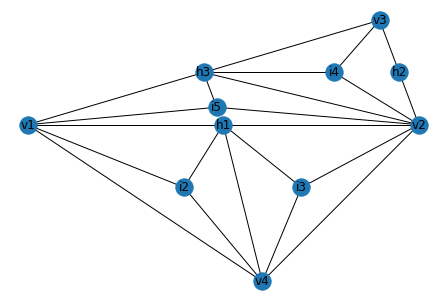

In [18]:
G = get_test_graph()
print(find_graph_P8(G, "i1"))

# P9

In [12]:
def find_graph_P9(G, i):
    # funkcje pomocnicze:
    def find_hanging_node(common_neighbors):
        if common_neighbors:
            if any(common_neighbor.startswith('h') for common_neighbor in common_neighbors):
                hanging_node = next((common_neighbor for common_neighbor in common_neighbors if common_neighbor.startswith('h')), None)
                return hanging_node
        return None
    
    def get_important_hyper_edge(hyper_edges):
        # wyznaczenie najdłuższej hiperkrawędzi
        hyper_edges_lengths = []
        for v1, h, v2 in hyper_edges:
            edge1 = G.edges[v1, h]
            edge2 = G.edges[v2, h]
            length = edge1['length'] + edge2['length']
            hyper_edges_lengths.append(length)
        return hyper_edges[hyper_edges_lengths.index(max(hyper_edges_lengths))]
    
    def get_position_of_new_node(v1, v2, v3):
        # współrzędne dla nowego wierzchołka
        v1_node = G.nodes[v1]
        v2_node = G.nodes[v2]
        v3_node = G.nodes[v3]
        
        pos_x = (v1_node['x'] + v2_node['x'] + v3_node['x']) / 3
        pos_y = (v1_node['y'] + v2_node['y'] + v3_node['y']) / 3
        pos_z = (v1_node['z'] + v2_node['z'] + v3_node['z']) / 3
        return pos_x, pos_y, pos_z
    
    def get_highest_edge_number():
        # najwyższy zajęty indeks krawędzi
        numbers = []
        for e in G.edges:
            numbers.append(int(G.edges[e]['name'][1:]))
        return max(numbers)
    
    def get_dist(v1_name, v2_name):
        # odległość między danymi wierzchołkami
        v1 = G.nodes[v1_name]
        v2 = G.nodes[v2_name]
        return math.sqrt(math.pow(v1['x'] - v2['x'], 2) + math.pow(v1['y'] - v2['y'], 2) + math.pow(v1['z'] - v2['z'], 2))
    
    def add_new_edge(vertex1, vertex2):
        # nowa krawedz o poprawnej nazwie
        current_e_number = get_highest_edge_number() + 1
        new_e_name = "e" + str(current_e_number)
        length = get_dist(vertex1, vertex2)
        G.add_edge(vertex1, vertex2, length=length, name=new_e_name)
        print('Dodano krawędź', new_e_name, 'pomiędzy', vertex1, 'oraz', vertex2)
    
    
    # i musi mieć 3 dokładnie 3 sąsiadów
    if len(list(G.neighbors(i))) != 3:
        return False
    
    [v1, v2, v3] = list(G.neighbors(i))

    # wszystkie 3 krawedzie (v1,v2), (v2,v3) oraz (v3,v1) mają zawierać hanging node'y
    h_v1v2 = None # tutaj bede przechowywal wierzcholek h między wierzchołkami v1 i v2
    h_v1v3 = None # analogicznie dla v1 i v3
    h_v2v3 = None # analogicznie dla v2 i v3

    v1v2_common_neighbors = sorted(nx.common_neighbors(G, v1, v2))
    v1v3_common_neighbors = sorted(nx.common_neighbors(G, v1, v3))
    v2v3_common_neighbors = sorted(nx.common_neighbors(G, v2, v3))
            
    h_v1v2 = find_hanging_node(v1v2_common_neighbors)
    h_v1v3 = find_hanging_node(v1v3_common_neighbors)
    h_v2v3 = find_hanging_node(v2v3_common_neighbors)
    
    if h_v1v2 is None or h_v1v3 is None or h_v2v3 is None:
        return False

    print (h_v1v2, 'jest hanging nodem dla:', v1, 'oraz', v2)
    print (h_v1v3, 'jest hanging nodem dla:', v1, 'oraz', v3)
    print (h_v2v3, 'jest hanging nodem dla:', v2, 'oraz', v3)
    
    # sprawdzenie zadanego warunku:
    # sposrod  trzech hiperkrawędzi [(v1, hv1v2, v2), (v1, hv1v3, v3), (v2, hv2v3, v3)] trzeba wybrac tą, 
    # która ma największą długość, ten wybór determinuje potem jak mamy przekształcać graf
    # w tym celu v1, v2, v3 zostana przeindeksowane tak, aby odzwierciedlały schemat z dokumentu
    old_v1 = v1
    old_v2 = v2
    old_v3 = v3
    
    hyper_edges = [
        (v1, h_v1v2, v2),
        (v1, h_v1v3, v3),
        (v2, h_v2v3, v3),
    ]
    
    v1, h_to_remove, v2 = get_important_hyper_edge(hyper_edges)
    # ta hiperkrawedz bedzie modyfikowana, hanging node h_to_remove zostanie usunięty/zastąpiony nowym v
    
    print('Hanging node, który zostanie usunięty:', h_to_remove, end=', ')
    print('jest sąsiadem:', v1, 'oraz', v2)
    
    v3 = next(iter(set([old_v1, old_v2, old_v3]).difference(set([v1, v2]))))
    ## v3 - wierzchołek, który nie nalezy do tej hiperkrawedzi
    
    # przebudowa grafu
    
    # usuwanie wierzchołków
    G.remove_node(i)
    print('Usuwam wierzchołek:', i)
    
    # usuwam wierzchołek h
    h_node = G.nodes[h_to_remove]
    h_x, h_y, h_z = h_node['x'], h_node['y'], h_node['z']
    l1 = G.edges[v1, h_to_remove]['length']
    l2 = G.edges[v2, h_to_remove]['length'] # te parametry będę użyte dla nowego wierzchołka v
    
    G.remove_node(h_to_remove)
    print('Usuwam wierzchołek:', h_to_remove)
    
    # dodawanie nowych wierzchołków: i1, i2, v
    # oczywiscie trzeba im nadac wolne indeksy
    
    # nowy wierzchołek typu v:
    last_v_index = next((x for x in sorted(list(G.nodes), reverse=True) if x.startswith('v')), None)
    current_number = int(last_v_index[1:]) + 1
    new_v_name = "v" + str(current_number)
    print ("Nowy wierzchołek typu v będzie się nazywał: " + new_v_name)
    G.add_node(new_v_name, x=h_x, y=h_y, z=h_z)   
    print('Dodano wierzchołek', new_v_name)
    
    # nowe wierzchołki typu i:
    last_i_index = next((x for x in sorted(list(G.nodes), reverse=True) if x.startswith('i')), None)
    current_number = int(last_i_index[1:]) + 1
    new_i1_name = "i" + str(current_number)
    new_i2_name = "i" + str(current_number + 1)
    print ("Nowy wierzchołek typu i będzie się nazywał: " + new_i1_name)
    print ("Nowy wierzchołek typu i będzie się nazywał: " + new_i2_name)

    # wyznaczam położenie wierzchołków i1, i2
    i1_pos_x, i1_pos_y, i1_pos_z = get_position_of_new_node(new_v_name, v3, v1)
    i2_pos_x, i2_pos_y, i2_pos_z = get_position_of_new_node(new_v_name, v3, v2)
    
    attrs = {}
    
    G.add_node(new_i1_name, x=i1_pos_x, y=i1_pos_y, z=i1_pos_z)
    attrs[new_i1_name] = {'R': False}
    print('Dodano wierzchołek', new_i1_name)
    
    G.add_node(new_i2_name, x=i2_pos_x, y=i2_pos_y, z=i2_pos_z)
    attrs[new_i2_name] = {'R': False}
    print('Dodano wierzchołek', new_i2_name)
    
    # dodajemy nowe krawędzie
    
    # dla nowych i1, i2
    edges_to_add = [
        [v1, new_v_name],
        [v2, new_v_name],
        [new_i1_name, v1],
        [new_i1_name, v3],
        [new_i1_name, new_v_name],
        [new_i2_name, v2],
        [new_i2_name, v3],
        [new_i2_name, new_v_name],
        [new_v_name, v3],
    ]
    
    for vertex1, vertex2 in edges_to_add:
        add_new_edge(vertex1, vertex2)
         
    nx.set_node_attributes(G, attrs)
    nx.draw(G, build_pos_dict(G), with_labels = True)
    return True

Należy wprowadzić nowy przykład grafu, w którym realizowany jest układ P9.

In [13]:
def get_another_test_graph():
    G = nx.Graph()
    vertices = {"v1": (0, 30, 0), 
                "v2": (10, 30, 0), 
                "v3": (9, 40, 0), 
                "h1": (5, 30, 0), 
                "h2": (9.5, 35, 0),
                "h3": (4.5, 35, 0), # nowy hanging node
                "i1": (7, 34, 0), 
                "v4": (6, 15, 0), 
                "i2": (4, 24, 0),
                "i3": (7, 24, 0)}
    for n, c in vertices.items():
        G.add_node(n, x=c[0], y=c[1], z=c[2])

    attrs = {"i1": {'R': True}, 
             "i2": {'R': False}, 
             "i3": {'R': False}}

    G.add_edge("v1", "h1", length = 5, name = 'e1')
    G.add_edge("v2", "h2", length = 5.0249, name = 'e2')
    G.add_edge("v2", "h1", length = 5, name = 'e3')
    G.add_edge("v3", "h2", length = 5.0249, name = 'e4')
#     G.add_edge("v3", "v1", length = 13.4536, name = 'e5')
    G.add_edge("v1", "i1", length = 8.0623, name = 'e6')
    G.add_edge("v2", "i1", length = 5, name = 'e7')
    G.add_edge("v3", "i1", length = 6.3246, name = 'e8')
    G.add_edge("v4", "v1", length = 16.1555, name = 'e9')
    G.add_edge("v4", "v2", length = 15.5242, name = 'e10')
    G.add_edge("v4", "h1", length = 15.0333, name = 'e11')
    G.add_edge("v1", "i2", length = 7.2111, name = 'e12')
    G.add_edge("h1", "i2", length = 6.0828, name = 'e13')
    G.add_edge("v4", "i2", length = 9.2195, name = 'e14')
    G.add_edge("i3", "v4", length = 9.0554, name = 'e15')
    G.add_edge("i3", "v2", length = 6.7082, name = 'e16')
    G.add_edge("i3", "h1", length = 6.3246, name = 'e17')
    # nowe krawędzie
    G.add_edge("v1", "h3", length = 6.7268, name = 'e18')
    G.add_edge("v3", "h3", length = 6.7268, name = 'e19')
    
    nx.set_node_attributes(G, attrs)
    
    return G

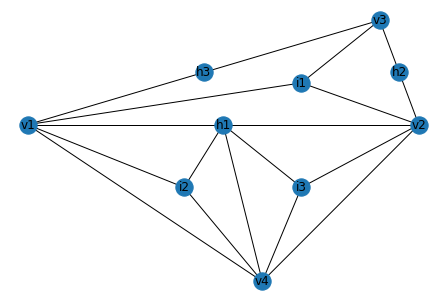

In [14]:
G2 = get_another_test_graph()
nx.draw(G2, build_pos_dict(G2), with_labels = True)

In [15]:
find_graph_P9(G, "i1")

False

h1 jest hanging nodem dla: v1 oraz v2
h3 jest hanging nodem dla: v1 oraz v3
h2 jest hanging nodem dla: v2 oraz v3
Hanging node, który zostanie usunięty: h3, jest sąsiadem: v1 oraz v3
Usuwam wierzchołek: i1
Usuwam wierzchołek: h3
Nowy wierzchołek typu v będzie się nazywał: v5
Dodano wierzchołek v5
Nowy wierzchołek typu i będzie się nazywał: i4
Nowy wierzchołek typu i będzie się nazywał: i5
Dodano wierzchołek i4
Dodano wierzchołek i5
Dodano krawędź e18 pomiędzy v1 oraz v5
Dodano krawędź e19 pomiędzy v3 oraz v5
Dodano krawędź e20 pomiędzy i4 oraz v1
Dodano krawędź e21 pomiędzy i4 oraz v2
Dodano krawędź e22 pomiędzy i4 oraz v5
Dodano krawędź e23 pomiędzy i5 oraz v3
Dodano krawędź e24 pomiędzy i5 oraz v2
Dodano krawędź e25 pomiędzy i5 oraz v5
Dodano krawędź e26 pomiędzy v5 oraz v2


True

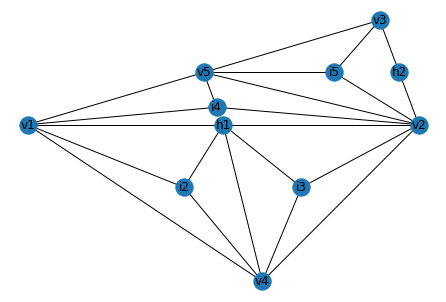

In [16]:
find_graph_P9(G2, "i1")